## NIPA 하반기 경진대회 예선

## Settings


In [ ]:
import pandas as pd
import numpy as np
import os
import shutil
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/인공지능 학습관련/NIPA_하반기 경진대회_사전검증
!pwd

/content/drive/My Drive/인공지능 학습관련/NIPA_하반기 경진대회_사전검증
/content/drive/My Drive/인공지능 학습관련/NIPA_하반기 경진대회_사전검증


## Data


In [ ]:
df = pd.read_csv('./train/train.tsv', sep='\t', header=None)
df.columns = ['file_name','plant','disease']
df

,file_name,plant,disease
0,3_5_1123.jpg,3,5
1,3_20_1048.jpg,3,20
2,4_2_401.jpg,4,2
3,4_7_740.jpg,4,7
4,4_11_93.jpg,4,11
...,...,...,...
15995,13_15_1600.jpg,13,15
15996,13_16_1570.jpg,13,16
15997,13_17_986.jpg,13,17
15998,13_18_4980.jpg,13,18


In [ ]:
df['comb_label'] = [str(a)+'_'+str(b) for a,b in zip(df.plant,df.disease)]
df

,file_name,plant,disease,comb_label
0,3_5_1123.jpg,3,5,3_5
1,3_20_1048.jpg,3,20,3_20
2,4_2_401.jpg,4,2,4_2
3,4_7_740.jpg,4,7,4_7
4,4_11_93.jpg,4,11,4_11
...,...,...,...,...
15995,13_15_1600.jpg,13,15,13_15
15996,13_16_1570.jpg,13,16,13_16
15997,13_17_986.jpg,13,17,13_17
15998,13_18_4980.jpg,13,18,13_18


In [ ]:
comb_label_sr = df.comb_label.value_counts().sort_index()
comb_label_sr

10_20    800
11_14    800
13_1     800
13_15    800
13_16    800
13_17    800
13_18    800
13_20    800
13_6     800
13_9     800
3_20     800
3_5      800
4_11     800
4_2      800
4_7      800
5_8      800
7_1      800
7_20     800
8_6      800
8_9      800
Name: comb_label, dtype: int64

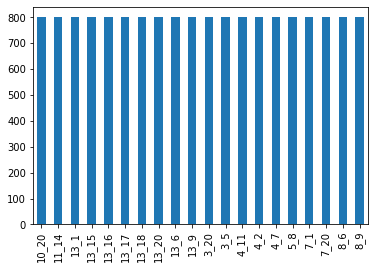

In [ ]:
comb_label_sr.plot.bar(x = 'index', rot = 90)

## Labeling the train set


In [ ]:
# Make model == feature model
feature_model = keras.applications.DenseNet201(weights="imagenet", include_top=False)

74842112/74836368 [==============================] - 0s 0us/step


In [ ]:
feature_model.trainable= False

In [ ]:
feature_model.summary()

In [ ]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

image_size = 224
batch_size = 1

train_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)

train_generator = train_datagen.flow_from_directory(directory = './train/train_comb',
                                                    subset = 'training',   
                                                    batch_size = batch_size,
                                                    seed = 64,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))

valid_generator = train_datagen.flow_from_directory(directory = './train/train_comb',
                                                    subset = 'validation',
                                                    batch_size = batch_size,
                                                    seed = 64,
                                                    shuffle = True,
                                                    class_mode = 'categorical',
                                                    target_size = (image_size,image_size))
print(train_generator.n)
print(valid_generator.n)

Found 12800 images belonging to 20 classes.
Found 3200 images belonging to 20 classes.
12800
3200


In [ ]:
train_generator.class_indices

{'10_20': 0,
 '11_14': 1,
 '13_1': 2,
 '13_15': 3,
 '13_16': 4,
 '13_17': 5,
 '13_18': 6,
 '13_20': 7,
 '13_6': 8,
 '13_9': 9,
 '3_20': 10,
 '3_5': 11,
 '4_11': 12,
 '4_2': 13,
 '4_7': 14,
 '5_8': 15,
 '7_1': 16,
 '7_20': 17,
 '8_6': 18,
 '8_9': 19}

In [ ]:
train_generator.reset()

## Feature extracting

In [ ]:
import numpy as np
from tqdm import tqdm

train_features = []
train_Y = []

# 처음 array

for idx in tqdm(range(train_generator.n)):

    x, y = train_generator.next()
    train_Y.extend(y)

    feature = feature_model.predict(x)
    train_features.extend(feature)
    
train_Y = np.array(train_Y)
train_features = np.array(train_features)

#array 전환 NasNet은 안됨
print(train_features.shape)
print(train_Y.shape)

In [ ]:
len(train_Y)

In [ ]:
len(train_features)

In [ ]:
valid_features = [] 
valid_Y = [] 

for idx in tqdm(range(valid_generator.n)):
    
    x, y = valid_generator.next()   
    valid_Y.extend(y)
  
    feature = feature_model.predict(x)
    valid_features.extend(feature)

#array 전환 NasNet은 안됨
valid_features = np.array(valid_features)
valid_Y = np.array(valid_Y)

print(valid_features.shape)
print(valid_Y.shape)


### Save feature vectors 

In [ ]:
np.save('./train_features_Dense.npy',train_features )
np.save('./train_Y_Dense.npy',train_Y )


In [ ]:
np.save('./valid_features_Dense.npy',valid_features )
np.save('./valid_Y_Dense.npy',valid_Y )


## Load feature vectors

In [ ]:
train_features = np.load('./train_features_Dense.npy')
train_Y = np.load('./train_Y_Dense.npy')

print("complete train data")


complete train data
complete valid data


In [ ]:
valid_features = np.load('./valid_features_Dense.npy')
valid_Y = np.load('./valid_Y_Dense.npy')

print("complete valid data")

complete valid data


## Classifier


In [ ]:
def build_model(feature_model, num_outputs=20):
    
    inputs = Input(shape=feature_model.output.shape[1:])
    
    x = GlobalAveragePooling2D()(inputs)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    
    outputs = Dense(num_outputs, activation='softmax', name='class_disease_output')(x)

    model = Model(inputs=inputs,
                 outputs = outputs)
    
    init_lr = 4e-4
    opt = Adam(lr=init_lr)
    model.compile(optimizer=opt, 
                  loss= 'categorical_crossentropy',
                  metrics='accuracy')
    
    
    return model
# feature_model.output.shape[1:]

TensorShape([None, None, 1920])

In [ ]:
model = build_model(feature_model)


model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 1920) 0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1920)              7680      
_________________________________________________________________
dense (Dense)                (None, 256)               491776    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)              

In [ ]:
weight_path="./model_best_checkpoint"

cp = ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=5, 
                                   min_lr=1e-6)
es = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=50) 
callbacks_list = [cp, es, reduceLROnPlat]

In [ ]:
initial_epochs = 200

history = model.fit(x = train_features,
                    y = train_Y,
                    validation_data = (valid_features, valid_Y),
                    epochs = initial_epochs,
                    batch_size = 32,
                    callbacks = callbacks_list
                    )

model.summary()

Epoch 1/100
400/400 [==============================] - ETA: 0s - loss: 3.0836 - accuracy: 0.1427
Epoch 00001: val_accuracy improved from -inf to 0.51719, saving model to .\model_best_checkpoint
400/400 [==============================] - 4s 9ms/step - loss: 3.0836 - accuracy: 0.1427 - val_loss: 1.9336 - val_accuracy: 0.5172
Epoch 2/100
398/400 [============================>.] - ETA: 0s - loss: 2.2454 - accuracy: 0.3110
Epoch 00002: val_accuracy improved from 0.51719 to 0.68625, saving model to .\model_best_checkpoint
400/400 [==============================] - 3s 9ms/step - loss: 2.2432 - accuracy: 0.3117 - val_loss: 1.3627 - val_accuracy: 0.6862
Epoch 3/100
393/400 [============================>.] - ETA: 0s - loss: 1.8231 - accuracy: 0.4315
Epoch 00003: val_accuracy improved from 0.68625 to 0.80219, saving model to .\model_best_checkpoint
400/400 [==============================] - 4s 9ms/step - loss: 1.8197 - accuracy: 0.4326 - val_loss: 1.0229 - val_accuracy: 0.8022
Epoch 4/100
400/400

Epoch 27/100
396/400 [============================>.] - ETA: 0s - loss: 0.2655 - accuracy: 0.9227
Epoch 00027: val_accuracy improved from 0.97375 to 0.97500, saving model to .\model_best_checkpoint
400/400 [==============================] - 4s 11ms/step - loss: 0.2656 - accuracy: 0.9227 - val_loss: 0.0948 - val_accuracy: 0.9750
Epoch 28/100
398/400 [============================>.] - ETA: 0s - loss: 0.2528 - accuracy: 0.9283
Epoch 00028: val_accuracy did not improve from 0.97500
400/400 [==============================] - 4s 10ms/step - loss: 0.2528 - accuracy: 0.9282 - val_loss: 0.0889 - val_accuracy: 0.9725
Epoch 29/100
395/400 [============================>.] - ETA: 0s - loss: 0.2478 - accuracy: 0.9300
Epoch 00029: val_accuracy improved from 0.97500 to 0.97656, saving model to .\model_best_checkpoint
400/400 [==============================] - 4s 10ms/step - loss: 0.2484 - accuracy: 0.9298 - val_loss: 0.0884 - val_accuracy: 0.9766
Epoch 30/100
396/400 [============================>.] -

Epoch 83/100
396/400 [============================>.] - ETA: 0s - loss: 0.1314 - accuracy: 0.9635
Epoch 00083: val_accuracy did not improve from 0.98188
400/400 [==============================] - 4s 9ms/step - loss: 0.1318 - accuracy: 0.9634 - val_loss: 0.0851 - val_accuracy: 0.9812
Epoch 84/100
400/400 [==============================] - ETA: 0s - loss: 0.1246 - accuracy: 0.9651
Epoch 00084: val_accuracy did not improve from 0.98188
400/400 [==============================] - 4s 9ms/step - loss: 0.1246 - accuracy: 0.9651 - val_loss: 0.0855 - val_accuracy: 0.9816
Epoch 85/100
397/400 [============================>.] - ETA: 0s - loss: 0.1245 - accuracy: 0.9636
Epoch 00085: val_accuracy did not improve from 0.98188
400/400 [==============================] - 4s 9ms/step - loss: 0.1242 - accuracy: 0.9638 - val_loss: 0.0860 - val_accuracy: 0.9812
Epoch 86/100
400/400 [==============================] - ETA: 0s - loss: 0.1328 - accuracy: 0.9630
Epoch 00086: val_accuracy did not improve from 0.9

In [ ]:
model2 = build_model(feature_model)
# 가중치 로드

model2.load_weights(weight_path)

# 모델 평가
print(model2.evaluate(valid_features, valid_Y))
model2.summary()


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f2c69f53cc0> and <tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f2bdfe54a90>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f2be3c8f5c0> and <tensorflow.python.keras.layers.core.Flatten object at 0x7f2bdfe54ba8>).
100/100 [==============================] - 1s 6ms/step - loss: 3.0743 - accuracy: 0.0497
[3.074281692504883, 0.049687501043081284]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 1920) 0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________


In [ ]:
model2.save('./model_best2.h5')

In [ ]:
# 학습 곡선
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

In [ ]:
model3= load_model('./model_best_Dense.h5')
print(model3.evaluate(valid_features, valid_Y))

100/100 [==============================] - 1s 5ms/step - loss: 0.0853 - accuracy: 0.9828
[0.08530951291322708, 0.9828125238418579]


In [ ]:
def build_finetuning(model, num_outputs=20):
    
    inputs = Input(shape=(image_size, image_size, 3))
    
    x = feature_model(inputs, training=False)
    outputs = model(x)

    model_fine = Model(inputs=inputs,
                 outputs = outputs)
    init_lr = 2e-6
    opt = Adam(lr=init_lr)
    model_fine.compile(optimizer=opt, 
                    loss= 'categorical_crossentropy',
                    metrics='accuracy')
        
    return model_fine

In [ ]:
# finetuning 모델 구축
finetune = build_finetuning(model3)

In [ ]:
feature_model.trainable = True

print("Number of layers in the base model: ", len(feature_model.layers))
fine_tune_at = 200

for layer in feature_model.layers[:fine_tune_at]:
    layer.trainable =  False

finetune.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, None, None, 1920)  18321984  
_________________________________________________________________
functional_3 (Functional)    (None, 20)                542676    
Total params: 18,864,660
Trainable params: 18,631,380
Non-trainable params: 233,280
_________________________________________________________________


In [ ]:
weight_path="./model_best_checkpoint"

cp = ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   min_lr=1e-7)
es = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) 
callbacks_list = [cp, es, reduceLROnPlat]

In [ ]:
fine_tune_epochs = 30

total_epochs =  initial_epochs + fine_tune_epochs

history_fine = finetune.fit(train_generator,
                    validation_data = valid_generator,
                    epochs = total_epochs,
                    initial_epoch= history.ephoch[-1]
                    batch_size = batch_size,
                    callbacks = callbacks_list
                    )

finetune.summary()

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig('DanseNet_graph.jpg')
plt.show()

In [ ]:
model2 = build_finetuning(model3)
# 가중치 로드

model2.load_weights(weight_path)


In [ ]:
finetune.evaluate(valid_generator)

125/125 [==============================] - 51s 404ms/step - loss: 0.0148 - accuracy: 0.9967


[0.014846083708107471, 0.996749997138977]

In [ ]:
model2.save('model_dense_best_tuning.h5')

In [ ]:
finetune.save('model_dense_best2.h5')

### prediction

In [ ]:
model = model2

In [ ]:
test_df = pd.read_csv('./test/test.tsv', sep='\t', header=None)
test_df.columns = ['filepath']
test_df.filepath = "./test/" + test_df.filepath
test_df

,filepath
0,./test/0.jpg
1,./test/1.jpg
2,./test/2.jpg
3,./test/3.jpg
4,./test/4.jpg
...,...
3992,./test/3992.jpg
3993,./test/3993.jpg
3994,./test/3994.jpg
3995,./test/3995.jpg


In [ ]:
print(len(test_df))

3997


In [ ]:
list(train_generator.class_indices.keys())

['10_20',
 '11_14',
 '13_1',
 '13_15',
 '13_16',
 '13_17',
 '13_18',
 '13_20',
 '13_6',
 '13_9',
 '3_20',
 '3_5',
 '4_11',
 '4_2',
 '4_7',
 '5_8',
 '7_1',
 '7_20',
 '8_6',
 '8_9']

In [ ]:
test_filenames = []
comb_pred = []
class_pred = []
disease_pred = []

comb_labels = list(train_generator.class_indices.keys())

for i in tqdm(range(len(test_df))):
    path = test_df.filepath[i]
    filename = path.split('/')[-1]
    test_filenames.append(filename)
    
    img_size = (224,224)
    img = keras.preprocessing.image.load_img(path, target_size=img_size)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    

    prediction = model.predict(img)
    prediction = prediction.argmax()
    prediction = comb_labels[prediction]
    
    c_pred, d_pred = prediction.split('_')
    

    
    class_pred.append(c_pred)
    disease_pred.append(d_pred)
    
    comb_pred.append(prediction)

In [ ]:
# pandas DF로 저장 후 tsv형식으로 저장/ model f1 score검사
import pandas as pd
import numpy as np

df = pd.DataFrame({'filename' : test_filenames, 'plant_class' : class_pred, 'disease_class':disease_pred})
df

,filename,plant_class,disease_class
0,0.jpg,3,5
1,1.jpg,3,20
2,2.jpg,4,2
3,3.jpg,4,7
4,4.jpg,4,11
...,...,...,...
3992,3992.jpg,13,15
3993,3993.jpg,13,16
3994,3994.jpg,13,17
3995,3995.jpg,13,18


In [ ]:
df.to_csv("class_disease_pred6.tsv", mode='w',sep='\t', index=False, header=None)